## Radio interferometría y síntesis de imágenes en astronomía - Laboratorio 1
### Vicente Mieres

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime, timedelta, timezone
import juliandate as jd
from numpy.fft import fftshift, ifftshift, ifft2
from scipy.spatial.distance import pdist
import math
from mpl_toolkits.axes_grid1 import make_axes_locatable


## Funciones y utilidades

### Funciones principales

In [3]:
def ecef_to_enu(ecef, array_center, phi=-33.45, lamb=-70.66, rad=True, is_array=True):
  '''
  Transform ecef coordinates into enu.
  '''
  if rad:
      phi, lamb = np.deg2rad(phi), np.deg2rad(lamb)

  cphi, clam = np.cos(phi), np.cos(lamb)
  sphi, slam = np.sin(phi), np.sin(lamb)


  R = np.array([[-slam,        clam,       0],
                [-clam*sphi,   -slam*sphi, cphi],
                [clam*cphi,    slam*cphi,  sphi]])

  dxyz = np.array(ecef) - np.array(array_center)

  enu = R @ dxyz.T if is_array else R @ dxyz

  return enu


def enu_to_altaz(enu, rad=True, is_array=True):
  '''
  Transform the enu vector to altitude and azimut
  '''

  if is_array:
    E, N, U = enu[0], enu[1], enu[2]
  else:
    E, N, U = float(enu[0]), float(enu[1]), float(enu[2])

  r = np.hypot(E, N)           
  El = np.arctan2(U, r)
  A = np.arctan2(E, N)
  
  if rad:
      return El, A % (2*np.pi)
  else:
      A_deg = np.degrees(A) % 360.0
      El_deg = np.degrees(El)
      return El_deg, A_deg

def local_sidereal_time(longitude=-70.76, utc=None, single=True):
  """
  Calculates the local sidereal time in Radians.
  """
  if utc is None:
    now = datetime.now(timezone.utc)
  else:
    now = utc

  jd_now = jd.from_gregorian(now.year, now.month, now.day, now.hour, now.minute, now.second)
  T = (jd_now - 2451545.0) / 36525
  theta = 280.46061837 + 360.98564736629 * (jd_now - 2451545) + (0.000387933 * T * T) - (T * T * T / 38710000.0)
  deg = theta % 360 + longitude

  h,m,s = degree_to_time(deg)
  rad = np.deg2rad(deg)
  
  if single: 
    return rad 
  else: 
    return deg, rad, h, m, s

def degree_to_time(theta, is_rad=False):
  """
  Converts degrees to hours, minutes and seconds.
  """
  if is_rad:
    theta = np.rad2deg(theta)

  h = int(theta/ 15)
  m = (int)(((theta / 15) - h) * 60)
  s = ((((theta / 15) - h) * 60) - m) * 60
  return h, m, s

def Rz(theta):
  c, s = np.cos(theta), np.sin(theta)
  return np.array([[ c, -s, 0],
                   [ s, c, 0],
                   [ 0, 0, 1]])

def Ry(theta):
  c, s = np.cos(theta), np.sin(theta)
  return np.array([[ c, 0, s],
  [ 0, 1, 0],
  [-s, 0, c]])


def hor_to_eq(enu, alt, az, phi=-33.45):
    """
    Transform ENU baseline into XYZ
    """
    phi = np.radians(phi)

    enu = np.asarray(enu)
    if enu.shape[-1] != 3:
        raise ValueError("El array ENU debe tener forma (..., 3)")

    E, N, U = enu[..., 0], enu[..., 1], enu[..., 2]

    b_norm = np.sqrt(E**2 + N**2 + U**2)

    X = b_norm * ( np.sin(alt)*np.cos(phi) - np.cos(alt)*np.sin(phi)*np.cos(az) )
    Y = b_norm * ( np.sin(az)*np.cos(alt) )
    Z = b_norm * ( np.sin(alt)*np.sin(phi) + np.cos(alt)*np.cos(phi)*np.cos(az) )

    return np.stack([X, Y, Z], axis=-1)

def eq_to_uvw(H, delta, hor_coords, is_array=True):
  '''
  Return the uvw coords of an antenna o antenna array 
  '''
  ch, cd = np.cos(H), np.cos(delta)
  sh, sd = np.sin(H), np.sin(delta)

  R = np.array([[sh,        ch,      0],
                [-sd*ch,   sd*sh,   cd],
                [cd*ch,   -cd*ch,   sd]])
  
  uvw = hor_coords @ R.T if is_array else R @ hor_coords

  return uvw

import numpy as np

def baselines(enu, include_conjugate=True):
    """
    Return all combination of baselines
    """
    enu = np.asarray(enu)
    N = len(enu)

    diff = enu[:, None, :] - enu[None, :, :]

    if include_conjugate:
        mask = ~np.eye(N, dtype=bool)
        baselines_result = diff[mask]
    else:
        i_indices, j_indices = np.triu_indices(N, k=1)
        baselines_result = diff[i_indices, j_indices]

    return baselines_result

def max_basline(baselines):
    """
    Return maximum baseline distance
    """
    distances = pdist(baselines)
    d_max = np.max(distances)
    return d_max

def eq_to_uvw_array(H_array, delta, r_eq):
    """
    Obtains uvw array from XYZ from a range of angle hours and static delta.
    """
    cd, sd = np.cos(delta), np.sin(delta)
    ch, sh = np.cos(H_array), np.sin(H_array)

    # Rotation matrix
    R = np.stack([
        np.stack([sh,        ch,        np.zeros_like(H_array)], axis=-1),
        np.stack([-sd*ch,    sd*sh,     np.full_like(H_array, cd)], axis=-1),
        np.stack([cd*ch,    -cd*sh,     np.full_like(H_array, sd)], axis=-1)
    ], axis=-2)  
    
    uvw = np.einsum('hij,bj->bhi', R, r_eq)  

    return uvw

def ra_dec_to_radians(radec, is_ra=True):
  """
  Converts right ascension and declination to Radians.
  """
  h, m, s = map(float, (radec.split(':')))
  
  value = abs(h) + m / 60 + s / 3600
  if is_ra:
    degrees = value * 15
  else:
    degrees = value if h >= 0 else -value
  return np.deg2rad(degrees)


def uvw_to_lambda(uvw, freq_hz):
    """
    Converts uvw coordinates into wavelenghts from a given frequency.
    """
    c = 299792458.0  # light speed
    lam = c / freq_hz
    uvw_lambda = uvw / lam
    return uvw_lambda, lam

def uvw_to_lambda_range(uvw, freqs_hz):
    """
    Converts uvw coordinates into wavelengths for a given range of frequencies.
    """
    c = 299792458.0  # Speed of light in m/s
    
    # Ensure frequencies are in a NumPy array for vectorized operations
    freqs_hz = np.asarray(freqs_hz)
    
    # Calculate all wavelengths at once, resulting in a 1D array
    lams = c / freqs_hz
    
    uvw_lambda = uvw[:, :, np.newaxis, :] / lams[np.newaxis, np.newaxis, :, np.newaxis]
    
    return uvw_lambda, lams

def plot_uv_coverage(
    uvw,
    unit="m",
    freq_hz=100e9,
    title=None,
    show_symmetry=True,
    show_center=True,
    center_color="white",
    center_size=50,
    color="deepskyblue",
    symmetry_color=None,
    cmap=None,
    color_by=None
):
    """
    Plot uvw coverage
    """
    # --- Selección de unidades ---
    if unit == "m":
        scale = 1.0
        label = "[m]"
    elif unit == "km":
        scale = 1e-3
        label = "[km]"
    elif unit.lower() in ["λ", "lambda", "wavelength"]:
        uvw, lam = uvw_to_lambda(uvw, freq_hz)
        scale = 1.0
        label = "[λ]"
    else:
        raise ValueError("Unidad no reconocida. Usa 'm', 'km' o 'lambda'.")

    u = uvw[..., 0] * scale
    v = uvw[..., 1] * scale

    if symmetry_color is None:
        if isinstance(color, str):
            symmetry_color = "royalblue" if color == "deepskyblue" else color
        else:
            symmetry_color = color

    plt.figure(figsize=(6, 6))

    if color_by is not None:
        sc = plt.scatter(u.flatten(), v.flatten(), c=color_by.flatten(),
                         s=2, cmap=cmap or "viridis", label="Baselines")
        plt.colorbar(sc, label="Color variable")
    else:
        plt.plot(u.flatten(), v.flatten(), ".", markersize=1, color=color, label="Baselines")

    if show_symmetry:
        plt.plot(-u.flatten(), -v.flatten(), ".", markersize=1,
                 alpha=0.4, color=symmetry_color, label="Simetría conjugada")

    # --- Punto central ---
    if show_center:
        plt.scatter(0, 0, color=center_color, s=center_size, zorder=5)

    plt.xlabel(f"u {label}")
    plt.ylabel(f"v {label}")
    plt.axis("equal")
    plt.grid(alpha=0.2)
    plt.legend(markerscale=5, fontsize=8, loc="upper right")

    if title:
        plt.title(title)
    else:
        plt.title(f"Cobertura UV ({unit})")

    plt.show()


def H_range(ra_rad, utc_start, utc_end, longitude=-70.76, step_minutes=5):
    """
    Calculate a series of physical Hour Angles (H) between two UTC dates.
    """

    if isinstance(utc_start, str):
        utc_start = datetime.fromisoformat(utc_start).replace(tzinfo=timezone.utc)
    if isinstance(utc_end, str):
        utc_end = datetime.fromisoformat(utc_end).replace(tzinfo=timezone.utc)

    # --- Range of hours ---
    n_steps = int((utc_end - utc_start).total_seconds() / 60 / step_minutes) + 1
    times_utc = [utc_start + timedelta(minutes=i * step_minutes) for i in range(n_steps)]

    # --- Calculates LST ---
    lst_rad = np.array([
        local_sidereal_time(longitude=longitude, utc=t, single=True)
        for t in times_utc
    ])

    # --- H = LST - RA ---
    H = lst_rad - ra_rad

    # --- Wraps to (-π, π] ---
    H = (H + np.pi) % (2 * np.pi) - np.pi

    return times_utc, H, lst_rad

def select_vla_frequencies(band_name, num_frequencies=4):
    """
    Selects a VLA band and generates a specified number of frequencies from its range.
    """
    band = band_name.upper() # Make it case-insensitive
    if band not in VLA_BANDS:
        raise ValueError(f"Band '{band}' not recognized. Available bands: {list(VLA_BANDS.keys())}")

    min_freq, max_freq = VLA_BANDS[band]
    
    # Generate evenly spaced frequencies within the selected band
    frequencies = np.linspace(min_freq, max_freq, num_frequencies)
    
    return frequencies


def direction_cosines(ra_rad, dec_rad, ra0_rad, dec0_rad):
    """
    Calculate direction cosines.
    """
    dalpha = ra_rad - ra0_rad
    cosd = np.cos(dec_rad)
    sind = np.sin(dec_rad)
    cosd0 = np.cos(dec0_rad)
    sind0 = np.sin(dec0_rad)

    l = cosd * np.sin(dalpha)
    m = sind * cosd0 - cosd * sind0 * np.cos(dalpha)
    n = sind * sind0 + cosd * cosd0 * np.cos(dalpha)
    return l, m, n

def visibilities_from_sources(uvw_lambda, sources, ra0_deg, dec0_deg, sigma_pb=0.05):
    """
    Calculate visibilities from a source array for multiple frequencies.
    Handles a 4D uvw_lambda array of shape (baselines, timesteps, frequencies, 3).
    """
    # u,v,w arrays
    u = uvw_lambda[..., 0] 
    v = uvw_lambda[..., 1] 
    w = uvw_lambda[..., 2] 

    ra0 = np.deg2rad(ra0_deg)
    dec0 = np.deg2rad(dec0_deg)

    ras = np.array([src['ra_deg'] for src in sources])
    decs = np.array([src['dec_deg'] for src in sources])
    S0s  = np.array([src.get('S0', 1.0) for src in sources])

    ras_rad = np.deg2rad(ras)
    decs_rad = np.deg2rad(decs)

    # l, m, n 
    l_src, m_src, n_src = direction_cosines(ras_rad, decs_rad, ra0, dec0)  # shape (Nsrc,)

    # Primary beam 
    A_src = np.exp(-(l_src**2 + m_src**2) / (2 * sigma_pb**2))  # shape (Nsrc,)

    V_total = np.zeros(u.shape, dtype=complex)

    two_pi_i = 2j * np.pi
    for ls, ms, ns, As, Ss in zip(l_src, m_src, n_src, A_src, S0s):
        phase = two_pi_i * (u * ls + v * ms + w * (ns - 1.0))
        V_s = As * Ss / ns * np.exp(phase)
        V_total += V_s

    # weights 
    omega = np.ones_like(V_total, dtype=float)
    
    return V_total, omega, l_src, m_src, n_src


def generate_random_sources(ra0_deg, dec0_deg, N=50, max_offset_deg=1.0, flux_range=(0.1, 2.0), seed=None):
    """
    Generate N point sources around the center (ra0, dec0) within a maximum radius of max_offset_deg.
    """
    rng = np.random.default_rng(seed)
    ras = ra0_deg + rng.uniform(-max_offset_deg, max_offset_deg, N)
    decs = dec0_deg + rng.uniform(-max_offset_deg, max_offset_deg, N)
    fluxes = rng.uniform(flux_range[0], flux_range[1], N)

    sources = [{"ra_deg": ra, "dec_deg": dec, "S0": S} for ra, dec, S in zip(ras, decs, fluxes)]
    return sources


def grid_visibilities(V, uvw_lambda, du, dv, Npix=256):
    """
    Grids complex visibilities onto a regular (u, v) grid for multiple frequency channels.
    """
    n_freqs = V.shape[-1]
    u_coords = uvw_lambda[..., 0]
    v_coords = uvw_lambda[..., 1]

    VG = np.zeros((Npix, Npix, n_freqs), dtype=np.complex128)
    WG = np.zeros((Npix, Npix, n_freqs), dtype=np.float64)

    for f in range(n_freqs):
        u_f = u_coords[..., f].ravel()
        v_f = v_coords[..., f].ravel()
        V_f = V[..., f].ravel()
        omega_f = np.ones_like(V_f) # Pesos son 1

        i = np.rint(u_f / du).astype(int) + Npix // 2
        j = np.rint(v_f / dv).astype(int) + Npix // 2

        mask = (i >= 0) & (i < Npix) & (j >= 0) & (j < Npix)

        np.add.at(VG[..., f], (j[mask], i[mask]), omega_f[mask] * V_f[mask])
        np.add.at(WG[..., f], (j[mask], i[mask]), omega_f[mask])

    valid_cells = WG > 0
    VG[valid_cells] /= WG[valid_cells]

    return VG, WG

def to_fourier(visibilities):
    return fftshift(ifft2(ifftshift(visibilities)))

### Funciones secundarias

In [4]:
# utilidades 

def read_cfg_to_enu(filename, array_center=None ,phi=-33.44, lamb=-70.76, rad=True):
  '''
  Read file and return antenna config on ENU coords
  '''
  with open(filename, "r") as f:
    lines = f.readlines()

  coordsys = None 
  for line in lines:
        if line.startswith("# coordsys"):
            coordsys = line.split("=")[1].strip()
            break
  
  antennas = []
  for line in lines:
      if line.startswith("#") or not line.strip():
          continue
      parts = line.split()
      x, y, z = map(float, parts[:3])
      antennas.append([x, y, z])
  antennas = np.array(antennas)

  if coordsys == "LOC (local tangent plane)": return antennas.T
  elif coordsys == "XYZ":
     array_center = array_center if array_center is not None else antennas.mean(axis=0)
     enu_antennas = ecef_to_enu(antennas, array_center, phi, lamb, rad)
     return np.array(enu_antennas)
  else:
    raise ValueError(f"coordsys desconocido: {coordsys}")

import numpy as np
import matplotlib.pyplot as plt

def plot_antennas(enu_coords, labels=True, title="Configuración de Antenas", unit="m"):
    """
    Muestra la configuración de antenas a partir de sus coordenadas ENU.

    Parámetros
    ----------
    enu_coords : ndarray (N,3)
        Arreglo con las coordenadas [E, N, U] de cada antena (en metros).
    labels : bool
        Si True, muestra el índice de cada antena en el gráfico.
    title : str
        Título del gráfico.
    unit : {"m", "km"}
        Unidad en la que se mostrarán las coordenadas en el gráfico.
        Siempre se asume que enu_coords está en metros internamente.
    """

    enu_coords = np.array(enu_coords)

    # --- Conversión de unidades ---
    if unit == "m":
        scale = 1
        unit_label = "m"
    elif unit == "km":
        scale = 1e-3
        unit_label = "km"
    else:
        raise ValueError(f"Unidad desconocida: {unit}. Usa 'm' o 'km'.")

    E, N, U = enu_coords[:, 0] * scale, enu_coords[:, 1] * scale, enu_coords[:, 2] * scale

    # --- Gráfico ---
    fig = plt.figure(figsize=(12, 6))

    # Vista en planta (E-N)
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.scatter(E, N, c='black', marker='o')
    if labels:
        for i, (e, n) in enumerate(zip(E, N)):
            ax1.text(e, n, str(i), fontsize=9, ha='right')
    ax1.set_xlabel(f"East [{unit_label}]")
    ax1.set_ylabel(f"North [{unit_label}]")
    ax1.set_title("Vista en planta (E-N)")
    ax1.grid(True)
    ax1.axis('equal')

    # Vista en perfil (N-U)
    ax2 = fig.add_subplot(1, 2, 2)
    ax2.scatter(N, U, c='darkblue', marker='o')
    if labels:
        for i, (n, u) in enumerate(zip(N, U)):
            ax2.text(n, u, str(i), fontsize=9, ha='right')
    ax2.set_xlabel(f"North [{unit_label}]")
    ax2.set_ylabel(f"Up [{unit_label}]")
    ax2.set_title("Vista en perfil (N-U)")
    ax2.grid(True)
    ax2.axis('equal')

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()



def plot_all_dirty_images(VG, cell_size_arcsec):
    """
    Calcula y grafica la "dirty image" para cada canal de frecuencia en el cubo VG.
    """
    N, _, num_channels = VG.shape
    
    # Configura una grilla de subplots para mostrar todas las imágenes
    cols = math.ceil(math.sqrt(num_channels))
    rows = math.ceil(num_channels / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 6, rows * 5), squeeze=False)
    fig.suptitle('Dirty Images por Canal de Frecuencia', fontsize=16)

    # Calcula el campo de visión para etiquetar los ejes correctamente
    image_fov_arcsec = N * cell_size_arcsec
    extent = [-image_fov_arcsec / 2, image_fov_arcsec / 2, -image_fov_arcsec / 2, image_fov_arcsec / 2]
    extent=[-1,1,-1,1]

    for i in range(num_channels):
        ax = axes[i // cols, i % cols]
        
        # Selecciona el canal y calcula la imagen
        image = to_fourier(VG[..., i])
        intensity = np.abs(image)
        
        im = ax.imshow(intensity, origin='lower', cmap='inferno', 
                       extent=extent)
        
        ax.set_title(f'Canal {i}')
        ax.set_xlabel('Offset RA (arcsec)')
        ax.set_ylabel('Offset Dec (arcsec)')

        # 1. Crea un divisor para el eje actual
        divider = make_axes_locatable(ax)
        # 2. Añade un nuevo eje a la derecha, del 5% del ancho de la imagen y con un poco de padding
        cax = divider.append_axes("right", size="5%", pad=0.1)
        # 3. Dibuja el colorbar en ese nuevo eje específico
        fig.colorbar(im, cax=cax, label='Intensidad')

    # Oculta los ejes de los subplots que no se usen
    for i in range(num_channels, rows * cols):
        axes[i // cols, i % cols].axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


def calculate_and_plot_psf(WG, cell_size_arcsec):
    """
    Calcula y grafica la PSF ("dirty beam") para cada canal de frecuencia.
    """
    N, _, num_channels = WG.shape

    cols = math.ceil(math.sqrt(num_channels))
    rows = math.ceil(num_channels / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 5), squeeze=False)
    fig.suptitle('PSF ("Dirty Beam") por Canal de Frecuencia', fontsize=16)

    image_fov_arcsec = N * cell_size_arcsec
    extent = [-image_fov_arcsec / 2, image_fov_arcsec / 2, -image_fov_arcsec / 2, image_fov_arcsec / 2]
    extent=[-1,1,-1,1]

    for i in range(num_channels):
        ax = axes[i // cols, i % cols]
        
        # Para la PSF, usamos la grilla de pesos WG
        # Normalizamos la grilla de pesos para que el pico central de la PSF sea 1
        wg_channel = WG[..., i]
        if np.max(wg_channel) > 0:
            wg_channel = wg_channel / np.max(wg_channel)

        psf = to_fourier(wg_channel)
        intensity = np.abs(psf)
        
        im = ax.imshow(intensity, origin='lower', cmap='viridis', 
                       extent=extent)
        
        ax.set_title(f'PSF Canal {i}')
        ax.set_xlabel('Offset RA (arcsec)')
        ax.set_ylabel('Offset Dec (arcsec)')

        
        # 1. Crea un divisor para el eje actual
        divider = make_axes_locatable(ax)
        # 2. Añade un nuevo eje a la derecha, del 5% del ancho de la imagen y con un poco de padding
        cax = divider.append_axes("right", size="5%", pad=0.1)
        # 3. Dibuja el colorbar en ese nuevo eje específico
        fig.colorbar(im, cax=cax, label='Respuesta Normalizada')

    for i in range(num_channels, rows * cols):
        axes[i // cols, i % cols].axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


### Catálogo de Fuentes y Bandas de VLA

In [5]:
catalog = {
        'Sirius': {'RA': '06:45:09', 'Dec': '-16:42:58'},
        'Canopus': {'RA': '06:23:57', 'Dec': '-52:41:44'},
        'Centauri': {'RA': '14:39:36', 'Dec': '-60:50:02'},
        'Betelgeuse': {'RA': '05:55:10', 'Dec': '+07:24:25'},
        'Rigel': {'RA': '05:14:32', 'Dec': '-08:12:06'},
        'M31': {'RA': '00:42:44.3', 'Dec': '+41:16:09'},
        'M42': {'RA': '05:35:17.3', 'Dec': '-05:23:28'},
        '47_Tuc': {'RA': '00:24:05', 'Dec': '-72:04:52'},
        'LMC': {'RA': '05:23:35', 'Dec': '-69:45:22'}
    }

VLA_BANDS = {
    "L": (1.0e9, 2.0e9),
    "S": (2.0e9, 4.0e9),
    "C": (4.0e9, 8.0e9),
    "X": (8.0e9, 12.0e9),
    "Ku": (12.0e9, 18.0e9),
    "K": (18.0e9, 26.5e9),
    "Ka": (26.5e9, 40.0e9),
    "Q": (40.0e9, 50.0e9),
}

## Parte 1 Simulación de cobertura uv

En la siguiente sección, se presenta la parte 1 del laboratorio, la cual implementa una simulación de cobertura *uv*. Para esto primero se ha de escoger una configuración de antenas de un radiotelescopio, en caso particular **vla.a.cfg**, configuración correspondiente al *Very Large Array*. En el punto 1 podemos obversar la lectura de la configuración de antenas en formato ENU, y la definición de parámetros como la latitud y longitud en la que se encuentra el radiotelescopio. 

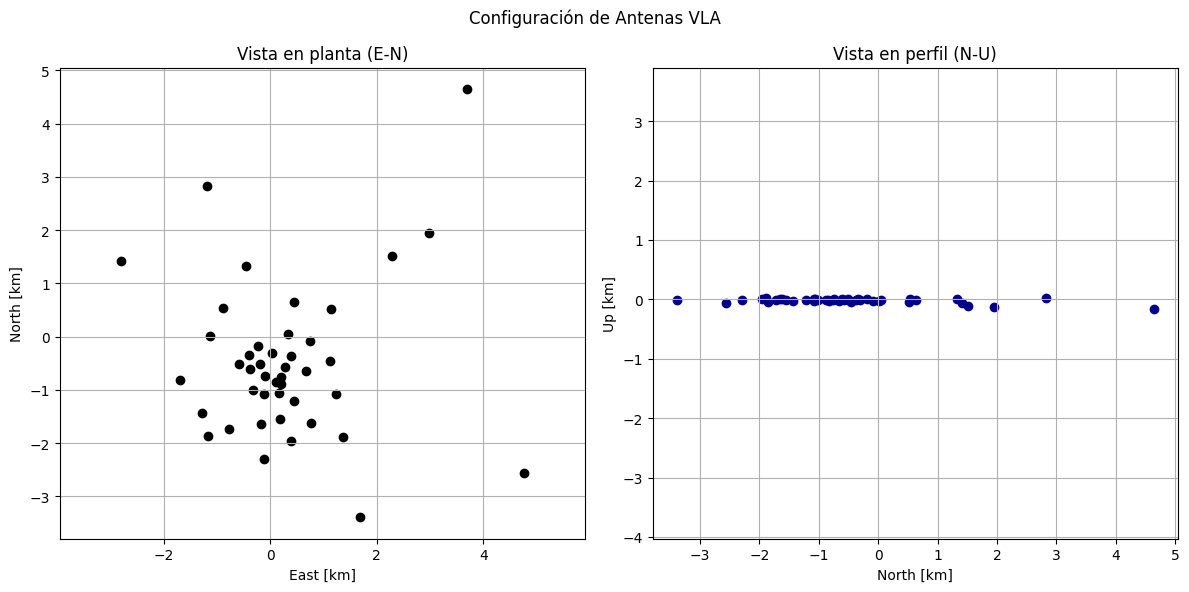

In [6]:
# 1. Lectura de antenas y definición de parámetros del arreglo
# Observatory VLA

latitude = 34.078749
longitude = -107.617728

enu = read_cfg_to_enu("../antenna_arrays/alma.cycle10.8.cfg")

plot_antennas(enu.T, labels=False, unit="km",title="Configuración de Antenas VLA")

En base al arreglo de antenas, se calculan las baselines formadas por los pares de antenas, para este caso particular 351 baselines.

In [7]:
# 2. Obtención de Baselines
baselines_enu = baselines(enu.T, False) 

print("Baselines: ", baselines_enu.shape)

baselines_enu

Baselines:  (903, 3)


array([[-1.96859581e+02,  1.02032260e+02,  2.55096833e+00],
       [-3.04094886e+02,  1.43801016e+01,  5.78051031e+00],
       [ 1.08477338e+02, -2.38374343e+02, -4.89302429e+00],
       ...,
       [ 1.79049200e+03, -4.50180200e+03,  6.60750000e+01],
       [ 1.07168500e+03, -7.19968500e+03,  9.86180000e+01],
       [-7.18807000e+02, -2.69788300e+03,  3.25430000e+01]],
      shape=(903, 3))

Luego, se realiza la transformación desde coordenadas ENU a Ecuatoriales, tal que:

ENU -> Horizontales (alt, az) -> Ecuatoriales (XYZ).

In [8]:
# 3. Transformacion baseline -> alt, az (Horizontales) -> XYZ (Ecuatoriales)
alt, az = enu_to_altaz(baselines_enu.T, rad=True)
r_eq = hor_to_eq(baselines_enu, alt, az, phi=latitude)

print("Altitud: ", alt.shape) 
print("Azimut: ", az.shape) 
print("XYZ: ", r_eq.shape) 


Altitud:  (903,)
Azimut:  (903,)
XYZ:  (903, 3)


Como última transformación, es necesario obtener el muestreo *uvw* generado por las antenas, esto para un centro de fase, es decir una Declinación y Ascensión Recta especifica (en este caso RA y Dec del cuerpo celeste Sirius), y una rango de horas angulo específicadas entre las 00:00 hrs del dia 10 de Octubre y las 12:00hrs del mismo día.

In [9]:
# 4. Transformación XYZ -> uvw

# Delta fijo -> Sirius
sirius_dec = catalog["Sirius"]['Dec']
sirius_ra = catalog["Sirius"]['RA']
delta_src = ra_dec_to_radians(sirius_dec, is_ra=False)
ra_src = ra_dec_to_radians(sirius_ra)

# Rango de horas angulo
times_utc, H, lst = H_range(
    ra_rad=ra_src,
    utc_start="2025-10-10 00:00:00",
    utc_end="2025-10-10 12:00:00",
    longitude=longitude,
    step_minutes=5
)

# Obtención muestreo
uvw = eq_to_uvw_array(H, delta_src, r_eq)
# uvw_freq = uvw_to_lambda(uvw, )

print("uvw:", uvw.shape)
print(uvw)

uvw: (903, 145, 3)
[[[ 1.84225926e+02  1.07785382e+02  6.01157507e+01]
  [ 1.86119446e+02  1.06620176e+02  5.62358785e+01]
  [ 1.87923897e+02  1.05443334e+02  5.23172646e+01]
  ...
  [-1.80999144e+02  5.49837256e+01 -1.15701703e+02]
  [-1.83033865e+02  5.61290721e+01 -1.11887961e+02]
  [-1.84980994e+02  5.72869464e+01 -1.08032504e+02]]

 [[ 2.98855151e+02  3.07037147e+01  4.95659332e+01]
  [ 3.00015240e+02  2.88195065e+01  4.32919503e+01]
  [ 3.01031755e+02  2.69284498e+01  3.69951636e+01]
  ...
  [-2.96691831e+02 -4.69590503e+00 -6.83067128e+01]
  [-2.98081426e+02 -2.82458725e+00 -6.20756521e+01]
  [-2.99328371e+02 -9.44974442e-01 -5.58169709e+01]]

 [[-8.42034022e+01 -2.33847580e+02 -8.26964217e+01]
  [-8.73870816e+01 -2.33307710e+02 -8.08987777e+01]
  [-9.05289419e+01 -2.32747938e+02 -7.90348648e+01]
  ...
  [ 7.90040693e+01 -1.48767975e+02  2.00599223e+02]
  [ 8.22517464e+01 -1.49275330e+02  1.98909849e+02]
  [ 8.54600611e+01 -1.49802997e+02  1.97152839e+02]]

 ...

 [[-1.31311799e

Finalmente se muestra el grafico con la covertura UV en KM.

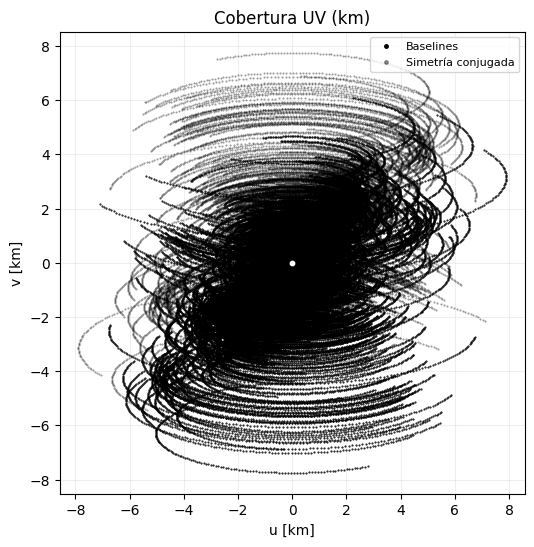

In [10]:
# 5. Gráfico uvw
plot_uv_coverage(uvw, unit='km', show_center=True, color='black', center_size=10, show_symmetry=True)

Como úiltimo paso, es necesario la cobertura uv a números de longitud de onda, esto se hace en el punto 6. Las frecuencias escogidas corresponden a las utilizadas por el radiostelescopio seleccionado, el detalle se puede encontrar en **VLA_BANDS**, o en https://science.nrao.edu/facilities/vla/docs/manuals/oss2016A/performance/bands

In [11]:
# 6. Transformación a longitud de Onda
frequencies = select_vla_frequencies("L", 4)
uvw_lambda, wavelengths = uvw_to_lambda_range(uvw, frequencies)

### Parte 1.1 Fuente Puntual

En esta sección se busca obtener el conjunto de visibilidades V, esto a partir de las ecuaciones presentadas en el enunciado, considerando consenos directors, un *primary beam* modelado por una Gaussiana y un valor aleatorio para la amplitud de la fuente $S_0$. Además se utiliza el mismo centro de fase presentado anteriormente, es decir Declinación y Ascensión recta de Sirius, y se generaron 100 fuentes puntuales aleatorias al rededor de este punto.

In [12]:
ra0_deg = np.degrees(ra_dec_to_radians(catalog['Sirius']['RA']))  # Sirius A
dec0_deg = np.degrees(ra_dec_to_radians(catalog['Sirius']['Dec']))
sources = generate_random_sources(ra0_deg, dec0_deg, N=100, max_offset_deg=0.1, flux_range=(0.2, 1.0), seed=42)

V, omega, l_src, m_src, n_src = visibilities_from_sources(uvw_lambda, sources, ra0_deg, dec0_deg)

print(f"Simuladas {len(sources)} fuentes puntuales.")
print(f"Visibilidades: {V.shape}")


Simuladas 100 fuentes puntuales.
Visibilidades: (903, 145, 4)


## Parte 2: Gridding
Como parte final del laboratorio, se solicita realizar un grideo al conjunto de visibilidades, esto con la finalidad de poder aplicar la trasnformada inversa de fourier (shifted) y poder visualizar la *dirty image* y la *psf*.

Este gridding se hace en función de los mencionando en el enunciado, resolución del radiotelescopio, distancia máxima entre baselines y un factor de oversampling para el calculo del tamaño de los píxeles.

In [13]:
# Resolucion
N = 512
# Distancion maxima entre baselines
Dmax = max_basline(baselines_enu)
oversampling_factor = 2

c = 299792458.0 
freq = np.min(frequencies)
min_wavelenghgt = c / freq
dx = dy = (min_wavelenghgt / Dmax) / oversampling_factor

du = 1.0 / (N * dx)
dv = du

In [14]:
# Gridding
VG, WG = grid_visibilities(V, uvw_lambda, du, dv,Npix=N)

C:\Users\vicen\AppData\Local\Temp\ipykernel_24120\368961241.py:417: ComplexWarning: Casting complex values to real discards the imaginary part
  np.add.at(WG[..., f], (j[mask], i[mask]), omega_f[mask])


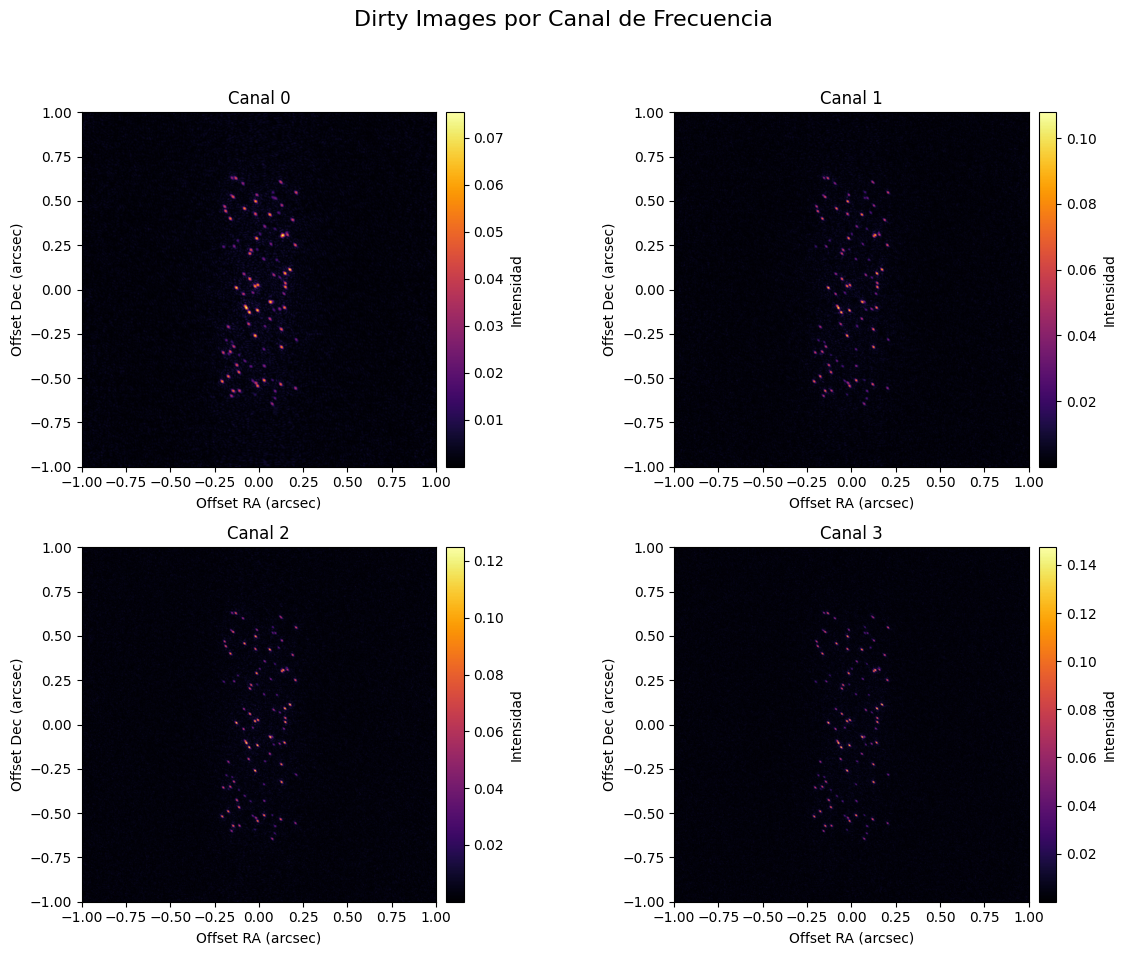

In [15]:
plot_all_dirty_images(VG, du)

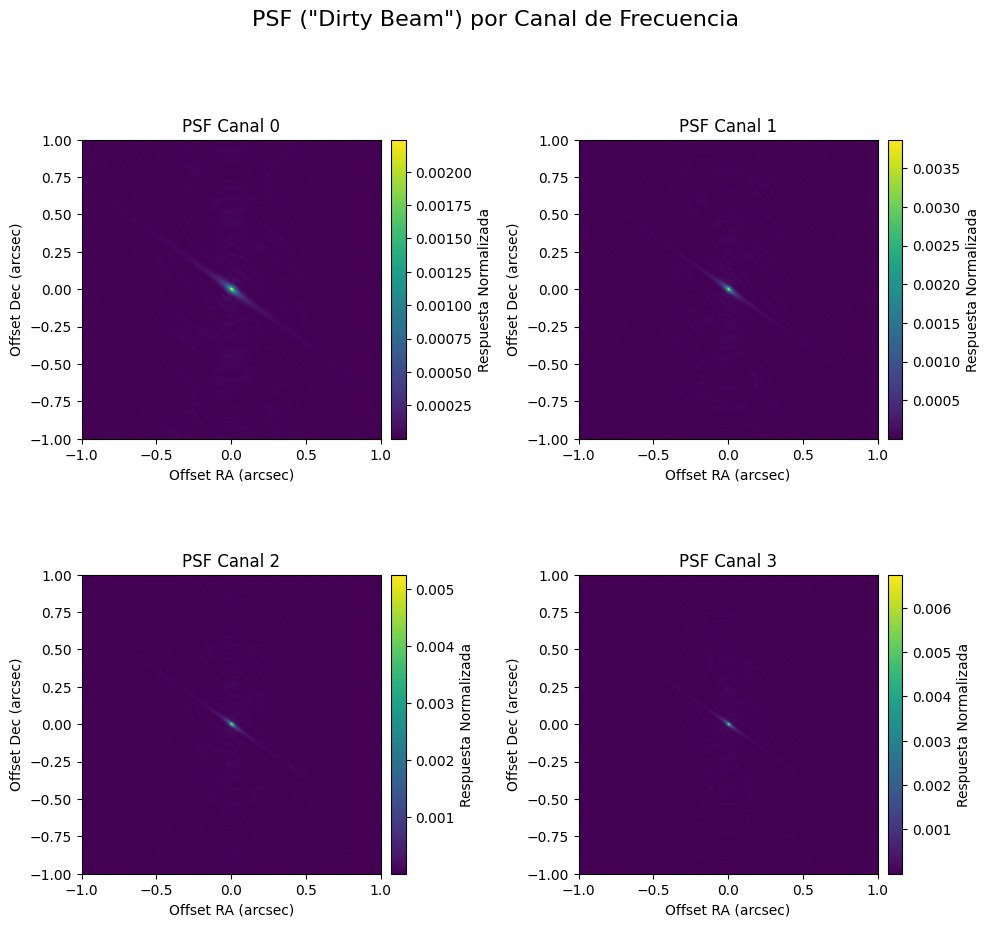

In [16]:
calculate_and_plot_psf(WG, du)